In [1]:
!pip install mplfinance yfinance torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

In [3]:
# Define the companies
companies = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
             'HINDUNILVR.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'LT.NS']

# Display company names for user selection
print("Select a company from the list below:")
for i, company in enumerate(companies):
    print(f"{i + 1}. {company}")

# Get user input
while True:
    choice = input("Enter the number of your chosen company: ")
    try:
        choice = int(choice)
        if 1 <= choice <= len(companies):
            selected_company = companies[choice - 1]
            break
        else:
            print("Invalid choice. Please enter a number within the range.")
    except ValueError:
        print("Invalid input. Please enter a number.")


Select a company from the list below:
1. RELIANCE.NS
2. TCS.NS
3. HDFCBANK.NS
4. ICICIBANK.NS
5. INFY.NS
6. HINDUNILVR.NS
7. SBIN.NS
8. BHARTIARTL.NS
9. ITC.NS
10. LT.NS


Enter the number of your chosen company:  2


In [4]:
# Load data for the selected company
ticker = yf.Ticker(selected_company)
data = ticker.history(period='2y')


In [5]:
# Function to calculate indicators
def calculate_indicators(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
    data['ROC'] = ((data['Close'] - data['Close'].shift(14)) / data['Close'].shift(14)) * 100
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = abs(data['Low'] - data['Close'].shift(1))
    data['True_Range'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['True_Range'].rolling(window=14).mean()
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1),
                           data['Volume'], -data['Volume']).cumsum()
    return data

# Apply the function to data
data = calculate_indicators(data)


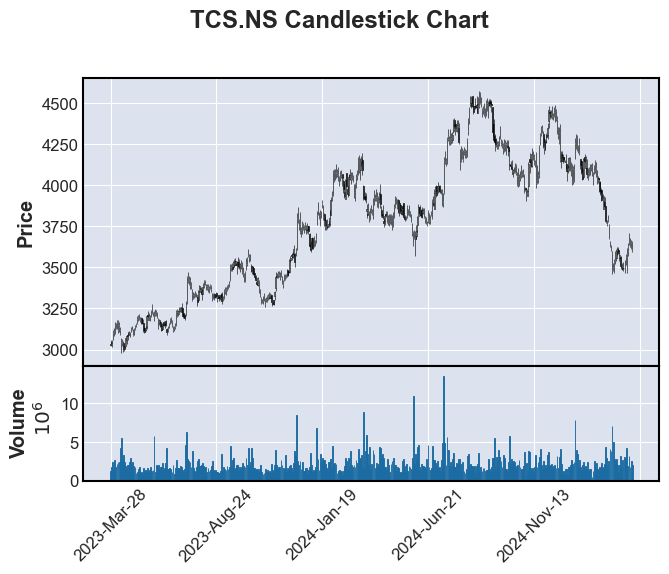

In [6]:
# Display Candlestick Chart
mpf.plot(data, type='candle', title=f'{selected_company} Candlestick Chart',
         ylabel='Price', ylabel_lower='Volume', volume=True)


In [7]:
# Preprocess data for prediction
def preprocess_data(data):
    close_prices = pd.to_numeric(data['Close'], errors='coerce').dropna().values

    if len(close_prices) == 0:
        return None, None, None, None

    price_mean = close_prices.mean()
    price_std = close_prices.std()
    normalized_prices = (close_prices - price_mean) / price_std

    seq_len = 100
    sequences = []
    labels = []
    
    for i in range(len(normalized_prices) - seq_len):
        seq = normalized_prices[i:i + seq_len]
        label = normalized_prices[i + seq_len]
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor(labels, dtype=torch.float32)

    return sequences, labels, price_mean, price_std

# Apply function
sequences, labels, price_mean, price_std = preprocess_data(data)

# Train-test split (80% train, 20% test)
train_size = int(len(sequences) * 0.8)
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]


Epoch 1, Loss: 0.7428292036056519
Epoch 101, Loss: 0.046024076640605927
Epoch 201, Loss: 0.035502299666404724
Epoch 301, Loss: 0.02649657055735588
Epoch 401, Loss: 0.020314250141382217
Epoch 501, Loss: 0.018541717901825905
Epoch 601, Loss: 0.017272256314754486
Epoch 701, Loss: 0.016247091814875603
Epoch 801, Loss: 0.014940260909497738
Epoch 901, Loss: 0.013600874692201614


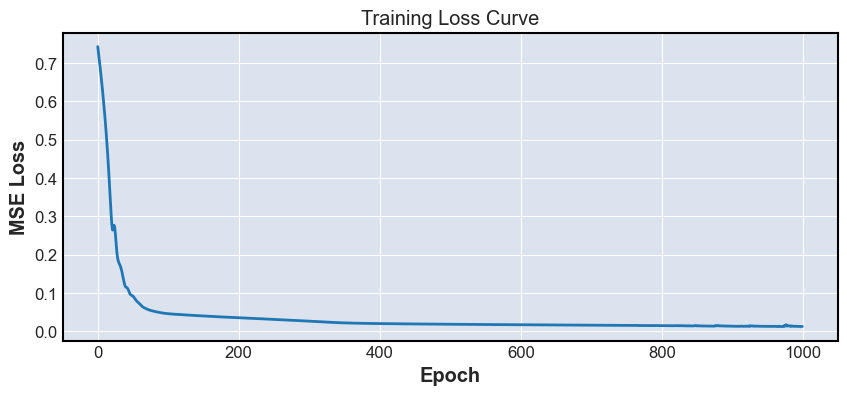

In [8]:
if sequences is not None and labels is not None:
    
    # Define the LSTM Model
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out[:, -1])
            return output

    # Parameters
    input_dim = 1
    hidden_dim = 50

    # Initialize model and optimizer
    model = LSTMModel(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 1000 
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(sequences)
        loss = nn.MSELoss()(outputs.squeeze(), labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.show()


Select a time frame for prediction:
1. 1 minute
2. 2 minutes
3. 3 minutes
4. 1 hour
5. 2 hours
6. 3 hours
7. 1 day
8. 2 days
9. 3 days
10. 1 week
11. 2 weeks
12. 3 weeks
13. 1 month
14. Custom


Enter the number for your chosen time frame:  11


Select a chart type for displaying predictions:
1. Line Chart
2. Scatter Plot
3. Bar Chart
4. Histogram
5. Candlestick Chart


Enter the number for your chosen chart type:  4


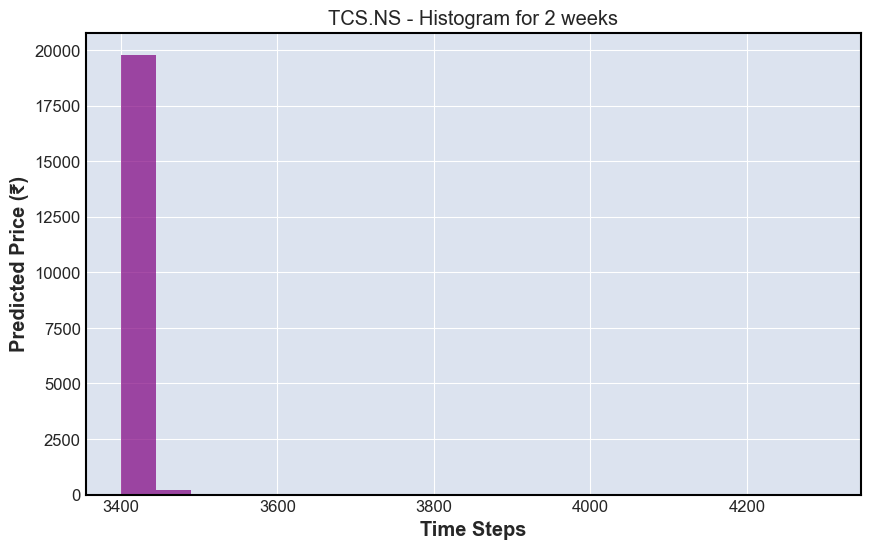

In [21]:
# Get user input for time frame
print("Select a time frame for prediction:")
time_frames = {
    1: ('1 minute', 1), 2: ('2 minutes', 2), 3: ('3 minutes', 3),
    4: ('1 hour', 60), 5: ('2 hours', 120), 6: ('3 hours', 180),
    7: ('1 day', 1440), 8: ('2 days', 2880), 9: ('3 days', 4320),
    10: ('1 week', 10080), 11: ('2 weeks', 20160), 12: ('3 weeks', 30240),
    13: ('1 month', 43800)
}

for key, value in time_frames.items():
    print(f"{key}. {value[0]}")
print("14. Custom")

while True:
    try:
        time_choice = int(input("Enter the number for your chosen time frame: "))
        if time_choice in time_frames:
            future_steps = time_frames[time_choice][1]
            break
        elif time_choice == 14:
            print("Select custom time unit:")
            print("1. Minutes")
            print("2. Hours")
            print("3. Days")
            print("4. Weeks")
            
            while True:
                custom_unit = int(input("Enter the number for your chosen unit: "))
                if custom_unit in [1, 2, 3, 4]:
                    max_limits = {1: 43800, 2: 730, 3: 30, 4: 4}
                    unit_labels = {1: "minutes", 2: "hours", 3: "days", 4: "weeks"}
                    
                    custom_value = int(input(f"Enter the number of {unit_labels[custom_unit]} (Max: {max_limits[custom_unit]}): "))
                    if 1 <= custom_value <= max_limits[custom_unit]:
                        future_steps = custom_value * {1: 1, 2: 60, 3: 1440, 4: 10080}[custom_unit]
                        break
                    else:
                        print("Invalid value. Please enter within the specified range.")
                else:
                    print("Invalid choice. Please select 1, 2, 3, or 4.")
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Get user input for chart type
print("Select a chart type for displaying predictions:")
chart_types = {
    1: 'Line Chart',
    2: 'Scatter Plot',
    3: 'Bar Chart',
    4: 'Histogram',
    5: 'Candlestick Chart'
}

for key, value in chart_types.items():
    print(f"{key}. {value}")

while True:
    try:
        chart_choice = int(input("Enter the number for your chosen chart type: "))
        if chart_choice in chart_types:
            selected_chart = chart_types[chart_choice]
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Predict future prices
future_prices = []
last_sequence = sequences[-1].unsqueeze(0)

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        output = model(last_sequence)
        future_prices.append(output.item())
        last_sequence = torch.cat((last_sequence[:, 1:], output.unsqueeze(-1)), dim=1)

# Denormalize future predictions
future_prices = (np.array(future_prices) * price_std) + price_mean



# Plot future predictions
plt.figure(figsize=(10, 6))
if selected_chart == 'Line Chart':
    plt.plot(future_prices, marker='o', linestyle='-', color='blue')
elif selected_chart == 'Scatter Plot':
    plt.scatter(range(len(future_prices)), future_prices, color='red')
elif selected_chart == 'Bar Chart':
    plt.bar(range(len(future_prices)), future_prices, color='green')
elif selected_chart == 'Histogram':
    plt.hist(future_prices, bins=20, color='purple', alpha=0.7)
elif selected_chart == 'Candlestick Chart':
    print("Candlestick charts require open, high, low, and close prices, which are unavailable for predictions.")
    selected_chart = 'Line Chart'
    plt.plot(future_prices, marker='o', linestyle='-', color='blue')

plt.title(f'{selected_company} - {selected_chart} for {time_frames.get(time_choice, ("Custom", ""))[0]}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Price (₹)')
plt.grid(True)
plt.show()


Select a time frame for prediction:
1. 1 minute
2. 2 minutes
3. 3 minutes
4. 1 hour
5. 2 hours
6. 3 hours
7. 1 day
8. 2 days
9. 3 days
10. 1 week
11. 2 weeks
12. 3 weeks
13. 1 month
14. Custom


Enter the number for your chosen time frame:  13


Select a chart type for displaying predictions:
1. Line Chart
2. Scatter Plot
3. Bar Chart
4. Histogram


Enter the number for your chosen chart type:  4


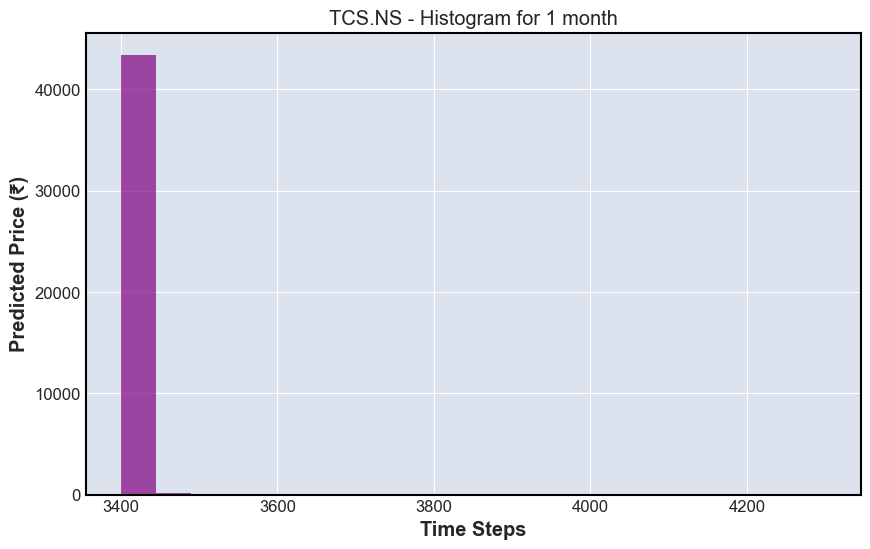

In [29]:
# Get user input for time frame
print("Select a time frame for prediction:")
time_frames = {
    1: ('1 minute', 1), 2: ('2 minutes', 2), 3: ('3 minutes', 3),
    4: ('1 hour', 60), 5: ('2 hours', 120), 6: ('3 hours', 180),
    7: ('1 day', 1440), 8: ('2 days', 2880), 9: ('3 days', 4320),
    10: ('1 week', 10080), 11: ('2 weeks', 20160), 12: ('3 weeks', 30240),
    13: ('1 month', 43800)
}

for key, value in time_frames.items():
    print(f"{key}. {value[0]}")
print("14. Custom")

while True:
    try:
        time_choice = int(input("Enter the number for your chosen time frame: "))
        if time_choice in time_frames:
            future_steps = time_frames[time_choice][1]
            break
        elif time_choice == 14:
            print("Select custom time unit:")
            print("1. Minutes")
            print("2. Hours")
            print("3. Days")
            print("4. Weeks")
            
            while True:
                custom_unit = int(input("Enter the number for your chosen unit: "))
                if custom_unit in [1, 2, 3, 4]:
                    max_limits = {1: 43800, 2: 730, 3: 30, 4: 4}
                    unit_labels = {1: "minutes", 2: "hours", 3: "days", 4: "weeks"}
                    
                    custom_value = int(input(f"Enter the number of {unit_labels[custom_unit]} (Max: {max_limits[custom_unit]}): "))
                    if 1 <= custom_value <= max_limits[custom_unit]:
                        future_steps = custom_value * {1: 1, 2: 60, 3: 1440, 4: 10080}[custom_unit]
                        break
                    else:
                        print("Invalid value. Please enter within the specified range.")
                else:
                    print("Invalid choice. Please select 1, 2, 3, or 4.")
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Get user input for chart type
print("Select a chart type for displaying predictions:")
chart_types = {
    1: 'Line Chart',
    2: 'Scatter Plot',
    3: 'Bar Chart',
    4: 'Histogram'
}

for key, value in chart_types.items():
    print(f"{key}. {value}")

while True:
    try:
        chart_choice = int(input("Enter the number for your chosen chart type: "))
        if chart_choice in chart_types:
            selected_chart = chart_types[chart_choice]
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Predict future prices
future_prices = []
last_sequence = sequences[-1].unsqueeze(0)

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        output = model(last_sequence)
        future_prices.append(output.item())
        last_sequence = torch.cat((last_sequence[:, 1:], output.unsqueeze(-1)), dim=1)

# Denormalize future predictions
future_prices = (np.array(future_prices) * price_std) + price_mean

# Plot future predictions
plt.figure(figsize=(10, 6))
if selected_chart == 'Line Chart':
    plt.plot(future_prices, marker='o', linestyle='-', color='blue')
elif selected_chart == 'Scatter Plot':
    plt.scatter(range(len(future_prices)), future_prices, color='red')
elif selected_chart == 'Bar Chart':
    plt.bar(range(len(future_prices)), future_prices, color='green')
elif selected_chart == 'Histogram':
    plt.hist(future_prices, bins=20, color='purple', alpha=0.7)

plt.title(f'{selected_company} - {selected_chart} for {time_frames.get(time_choice, ("Custom", ""))[0]}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Price (₹)')
plt.grid(True)
plt.show()


In [ ]:
# Get user input for time frame
'''
print("Select a time frame for prediction:")
time_frames = {
    1: ('1 minute', 1), 2: ('2 minutes', 2), 3: ('3 minutes', 3),
    4: ('1 hour', 60), 5: ('2 hours', 120), 6: ('3 hours', 180),
    7: ('1 day', 1440), 8: ('2 days', 2880), 9: ('3 days', 4320),
    10: ('1 week', 10080), 11: ('2 weeks', 20160), 12: ('3 weeks', 30240),
    13: ('1 month', 43800)
}

for key, value in time_frames.items():
    print(f"{key}. {value[0]}")
print("14. Custom")

while True:
    try:
        time_choice = int(input("Enter the number for your chosen time frame: "))
        if time_choice in time_frames:
            future_steps = time_frames[time_choice][1]
            break
        elif time_choice == 14:
            print("Select custom time unit:")
            print("1. Minutes")
            print("2. Hours")
            print("3. Days")
            print("4. Weeks")
            
            while True:
                custom_unit = int(input("Enter the number for your chosen unit: "))
                if custom_unit in [1, 2, 3, 4]:
                    max_limits = {1: 43800, 2: 730, 3: 30, 4: 4}
                    unit_labels = {1: "minutes", 2: "hours", 3: "days", 4: "weeks"}
                    
                    custom_value = int(input(f"Enter the number of {unit_labels[custom_unit]} (Max: {max_limits[custom_unit]}): "))
                    if 1 <= custom_value <= max_limits[custom_unit]:
                        future_steps = custom_value * {1: 1, 2: 60, 3: 1440, 4: 10080}[custom_unit]
                        break
                    else:
                        print("Invalid value. Please enter within the specified range.")
                else:
                    print("Invalid choice. Please select 1, 2, 3, or 4.")
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Get user input for chart type
print("Select a chart type for displaying predictions:")
chart_types = {
    1: 'Line Chart',
    2: 'Scatter Plot',
    3: 'Bar Chart',
    4: 'Histogram',
    5: 'Candlestick Chart'
}

for key, value in chart_types.items():
    print(f"{key}. {value}")

while True:
    try:
        chart_choice = int(input("Enter the number for your chosen chart type: "))
        if chart_choice in chart_types:
            selected_chart = chart_types[chart_choice]
            break
        else:
            print("Invalid choice. Please select a valid option.")
    except ValueError:
        print("Invalid input. Please enter a number.")

# Predict future prices
future_prices = []
last_sequence = sequences[-1].unsqueeze(0)

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        output = model(last_sequence)
        future_prices.append(output.item())
        last_sequence = torch.cat((last_sequence[:, 1:], output.unsqueeze(-1)), dim=1)

# Denormalize future predictions
future_prices = (np.array(future_prices) * price_std) + price_mean

# Plot future predictions
plt.figure(figsize=(10, 6))
if selected_chart == 'Line Chart':
    plt.plot(future_prices, marker='o', linestyle='-', color='blue')
elif selected_chart == 'Scatter Plot':
    plt.scatter(range(len(future_prices)), future_prices, color='red')
elif selected_chart == 'Bar Chart':
    plt.bar(range(len(future_prices)), future_prices, color='green')
elif selected_chart == 'Histogram':
    plt.hist(future_prices, bins=20, color='purple', alpha=0.7)
elif selected_chart == 'Candlestick Chart':
    print("Candlestick charts require open, high, low, and close prices, which are unavailable for predictions.")
    selected_chart = 'Line Chart'
    plt.plot(future_prices, marker='o', linestyle='-', color='blue')

plt.title(f'{selected_company} - {selected_chart} for {time_frames.get(time_choice, ("Custom", ""))[0]}')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Price (₹)')
plt.grid(True)
plt.show()